In [2]:
#!/usr/bin/env python
import sys
import os
import pickle as pkl
import warnings
import time
import glob

from functools import wraps, partial
from pathlib import Path
from multiprocessing import cpu_count
from multiprocessing.pool import Pool as Pool

import numpy as np
import matplotlib.pyplot as plt


from AnalyseCID import AnalyseCID
from utils import *
from utils_plot import *

sys.path.append('data\\config')
sys.path.append('ComputableInformationDensity_dev')
notebook_path = Path().resolve()
parent_dir = notebook_path.parent
sys.path.append(str(parent_dir))

from data.config.dicts import DATA_CONFIGS, FIG_FOLDER_CONFIGS

from ComputableInformationDensity_dev.cid import interlaced_time, cid2d
from ComputableInformationDensity_dev.computable_information_density import cid, cid_shuffle
from ComputableInformationDensity_dev.hilbert_curve import hilbert_curve, itter_hscan

from NematicAnalysis.utils import gen_clustering_metadata, get_defect_arr_from_frame, calc_weighted_mean, calc_acf_for_arr, \
    calc_autocorr, rdf2d_mod

plt.style.use('sg_article')
plt.rcParams.update({"text.usetex": True,})
#plt.rcParams['legend.handlelength'] = 0

In [13]:
base_path = f'Z:\\cid\\na'
save_path = f'data\\na'

save_figs = True
verbose = True

ordering='z' # 'h' for hilbert, 'z' for z-order
data_suffix = 'na512'  # 'sd', 'ndg', 's', 'f' or ''    
use_seq = False
seq_prefix = '_seq' if use_seq else ''
ordering_suffix = 'zorder' if ordering=='z' else ''

nbits = 8
window_size=256
nframes = 64
cg = 4

if ordering == 'h':
    output_suffix = f'_seq_nb{nbits}cg{cg}' if use_seq else f'_nb{nbits}cg{cg}'
elif ordering == 'z':
    output_suffix = f'_nx{window_size}nt{nframes}cg{cg}'

data_dict = DATA_CONFIGS #[data_suffix]
fig_folder_dict = FIG_FOLDER_CONFIGS

cid_dict = {
    'base_path': base_path,
    'save_path': save_path,
    'output_suffix': output_suffix,
    'nbits': nbits,
    'cg': cg,
    'verbose': verbose,
    'ddof': 1,   
    **data_dict[data_suffix]
}

#output_suffix = data_dict[data_suffix]['output_suffix']
figs_save_path = f'data\\figs\\{fig_folder_dict[data_suffix]}\\{output_suffix[1:]}'
if not os.path.exists(figs_save_path): 
    os.makedirs(figs_save_path)


ac = AnalyseCID(cid_dict,)
# Set figure save path
ac.figs_save_path = figs_save_path


* temporal corr
* corr func (version kris, version other)

In [23]:
save_fig=True
iterate_frames=True

window_size_dict = {'na512': [64,128,256],# 128, 256],
                    'na1024': [512],
                    'na2048': [1024],
                    'ndg': [64,128,256,],
                    'pol': [256],
                    's': [256, 512, 1024],
                    'abp': [64],
                    }
nsizes_dict = {'na512': [8,16,32,64],
                'na1024': [16,32,60],
                'na2048': [32,],
                'ndg': [16, 32, 64],
                'pol': [15,30,60],
                's': [1,2,4],
                'abp': [16,32],
                }
xlims_dict = {'na512': [0.018, 0.035],
                'na1024': [0.018, 0.035],
                'na2048': [0.018, 0.035],
                'ndg': None,
                'pol': None,
                's': None,
                'abp': None,
                }
ylims_dict = {'na512': [0, 0.8],
                'na1024': None,
                'na2048': [0, 0.8],
                'ndg': None,
                'pol': None,
                's': None,
                'abp': None,
                }


Text(0.5, 1.0, 'CID Shuffle Distribution at act=0.03')

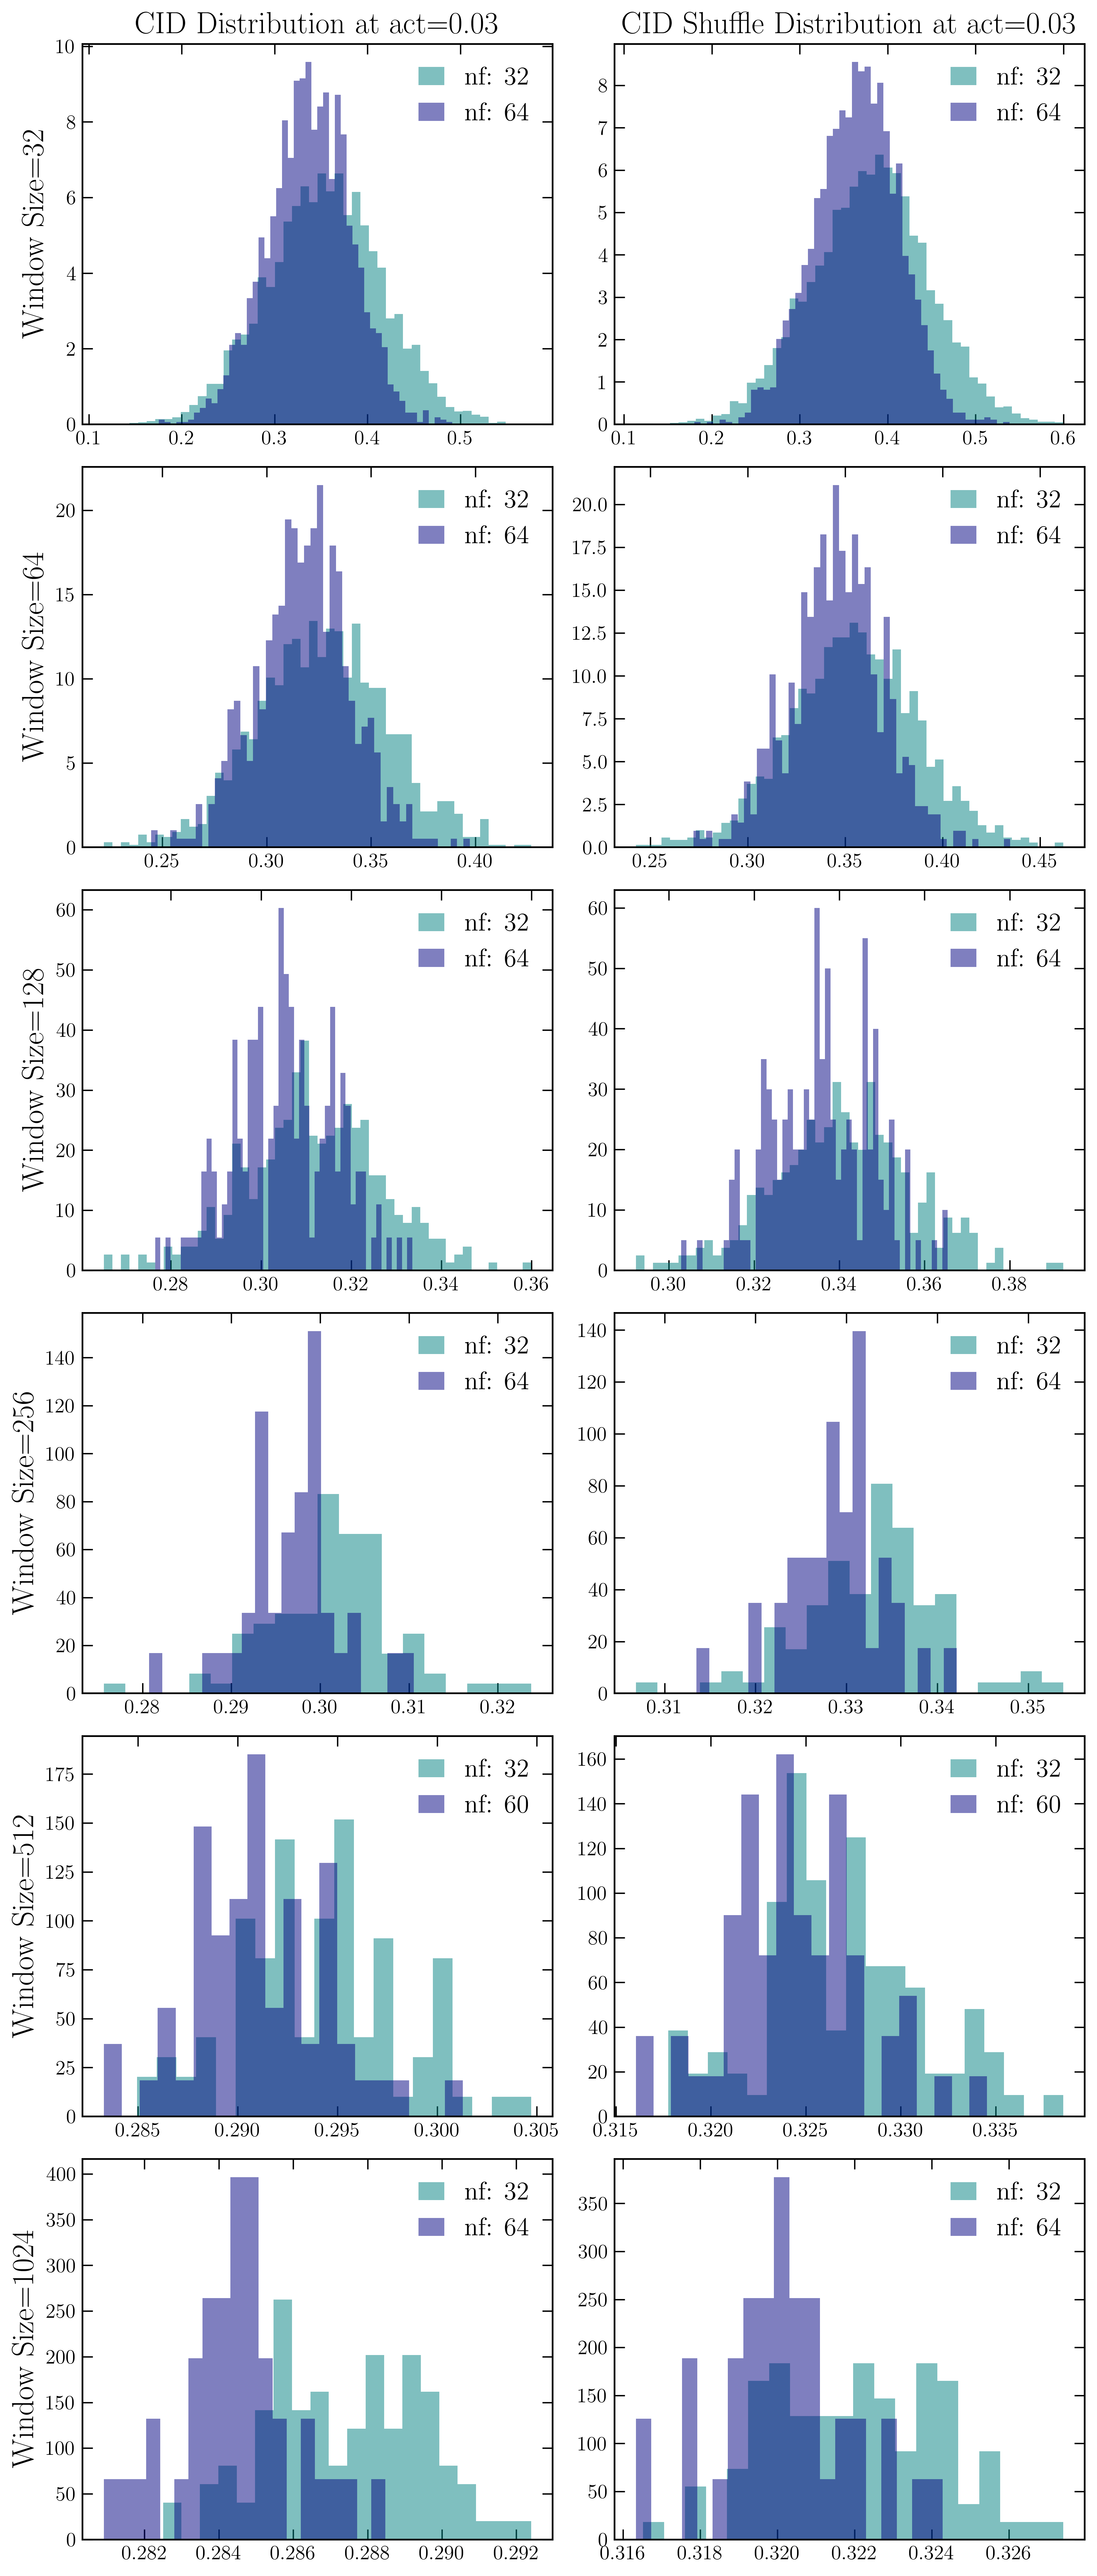

In [31]:
data_suffix='na512'
LL = data_dict[data_suffix]['L_list'][0]
save_fig=True
plot_abs = False
plot_cid_per = True 
zero_fluctuation_point = 0
mode = 'div' # 'cid' or 'div'

actp=0.03
bins=50
rangec_dict={0.022:(0.04,0.14), 0.04:(0.4,0.46)}
rangecs_dict={0.022:(0.06,0.18), 0.04:(0.42,0.48)}

fig_folder = fig_folder_dict[data_suffix]
figpath = f'data\\nematic\\figs\\{fig_folder}\\scaling'
if not os.path.exists(figpath):
    os.makedirs(figpath)
figpath

window_size_list = window_size_dict[data_suffix]
nsizes_list = nsizes_dict[data_suffix]

window_size_list = [32, 64, 128, 256, 512,1024]
nsizes_list = [32, 64]

#fig, ax = plt.subplots(ncols = 3 if plot_cid_per and mode=='cid' else 2, nrows = len(window_size_list), figsize=(15 if plot_cid_per and mode=='cid' else 10,3.5*len(window_size_list)))
nrows=len(window_size_list)
ncols=2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9,3.5*nrows))
marker_shape = ['d-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 
                    'd-', 'p-', 'H-', '8-', '1-', '2-']
for j, window_size in enumerate(window_size_list):

    axx = ax[j] if len(window_size_list) > 1 else ax
    if window_size ==512: 
        data_suffix='na1024'
        nsizes_list = [32, 60]
    if window_size ==1024:
        data_suffix='na2048'
        nsizes_list = [32,64]

    #cg = data_dict[data_suffix]['cg']
    LL = data_dict[data_suffix]['L_list'][0]
    ac_list = []
    for size in nsizes_list:
        cid_dict.update(data_dict[data_suffix])
        cg = cid_dict['cg']
        cid_dict.update({
            'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
        })
        ac_tmp = AnalyseCID(cid_dict, load_data=True)
        ac_list.append(ac_tmp)

    for i, size in enumerate(nsizes_list[:]):


        ac_tmp = ac_list[i]
        act = ac_tmp.act[LL].copy()
        
        cid = ac_tmp.cid[LL].copy()
        cid_shuffle = ac_tmp.cid_shuffle[LL].copy()
        frac = ac_tmp.frac[LL].copy()

        dcid = ac_tmp.dcid[LL].copy()
        dfrac = ac_tmp.dfrac[LL].copy()
        div_tav = dfrac.copy()
        div_tav[:,0] *= -1

        cid_tav = ac_tmp.cid_tav[LL].copy()
        frac_tav = ac_tmp.frac_tav[LL].copy()
        div_tav = frac_tav.copy()
        div_tav[...,0] = 1 - frac_tav[...,0]

        cid_var = ac_tmp.cid_var[LL].copy()
        div_var = ac_tmp.frac_var[LL].copy()

        normalizer = np.abs(zero_fluctuation_point - cid_tav[:,0])
        deriv_cid_per = dcid / normalizer[:, None]
        deriv_cid_per[:,1] = np.abs(deriv_cid_per[:,1])
        if plot_abs:
            deriv_cid_per = np.abs(deriv_cid_per)

        vals_av = cid_tav if mode == 'cid' else div_tav
        dvals = dcid if mode == 'cid' else dfrac

        act_idx = np.where(act==actp)[0][0]
        cid_vals_hist = cid[:, :, act_idx, :, 0].flatten()
        cid_shuffle_vals_hist = cid_shuffle[:, :, act_idx, :, 0].flatten()

        rangec = None #if actp not in rangec_dict else rangec_dict[actp]
        rangecs = None #if actp not in rangecs_dict else rangecs_dict[actp]
      #  rangec=(0.35,.6)
       # rangecs=(0.36,.62)
        bins=20 if window_size>=256 else 50
        axx[0].hist(cid_vals_hist, bins=bins, range=rangec , density=True, alpha=0.5, label=f'nf: {size}')
        axx[1].hist(cid_shuffle_vals_hist, bins=bins, range=rangecs , density=True, alpha=0.5, label=f'nf: {size}')

    axx[0].legend()
    axx[1].legend()
    axx[0].set_ylabel(f'Window Size={window_size}')
ax[0,0].set_title(f'CID Distribution at act={actp}')
ax[0,1].set_title(f'CID Shuffle Distribution at act={actp}')

In [12]:
window_size

64

In [11]:
ac.cid_params

{512: {'cid_mode': 'lz77',
  'dtype': numpy.uint8,
  'nshuffle': 16,
  'hyperwindow_shape': (8, 32, 32),
  'hyperwindow_shape_cg': (8, 8, 8),
  'compression_factor': 16,
  'coarse_graining_box_length': 4,
  'window_size': 32,
  'npartitions': 256,
  'num_frames': 1501,
  'njumps_between_frames': 1,
  'nframes_to_analyze': 400,
  'ncubes': 50,
  'nframes_per_cube': 8,
  'overlap': 0,
  'time_subinterval': 8,
  'first_frame_idx': 1101}}

In [20]:
ac_list

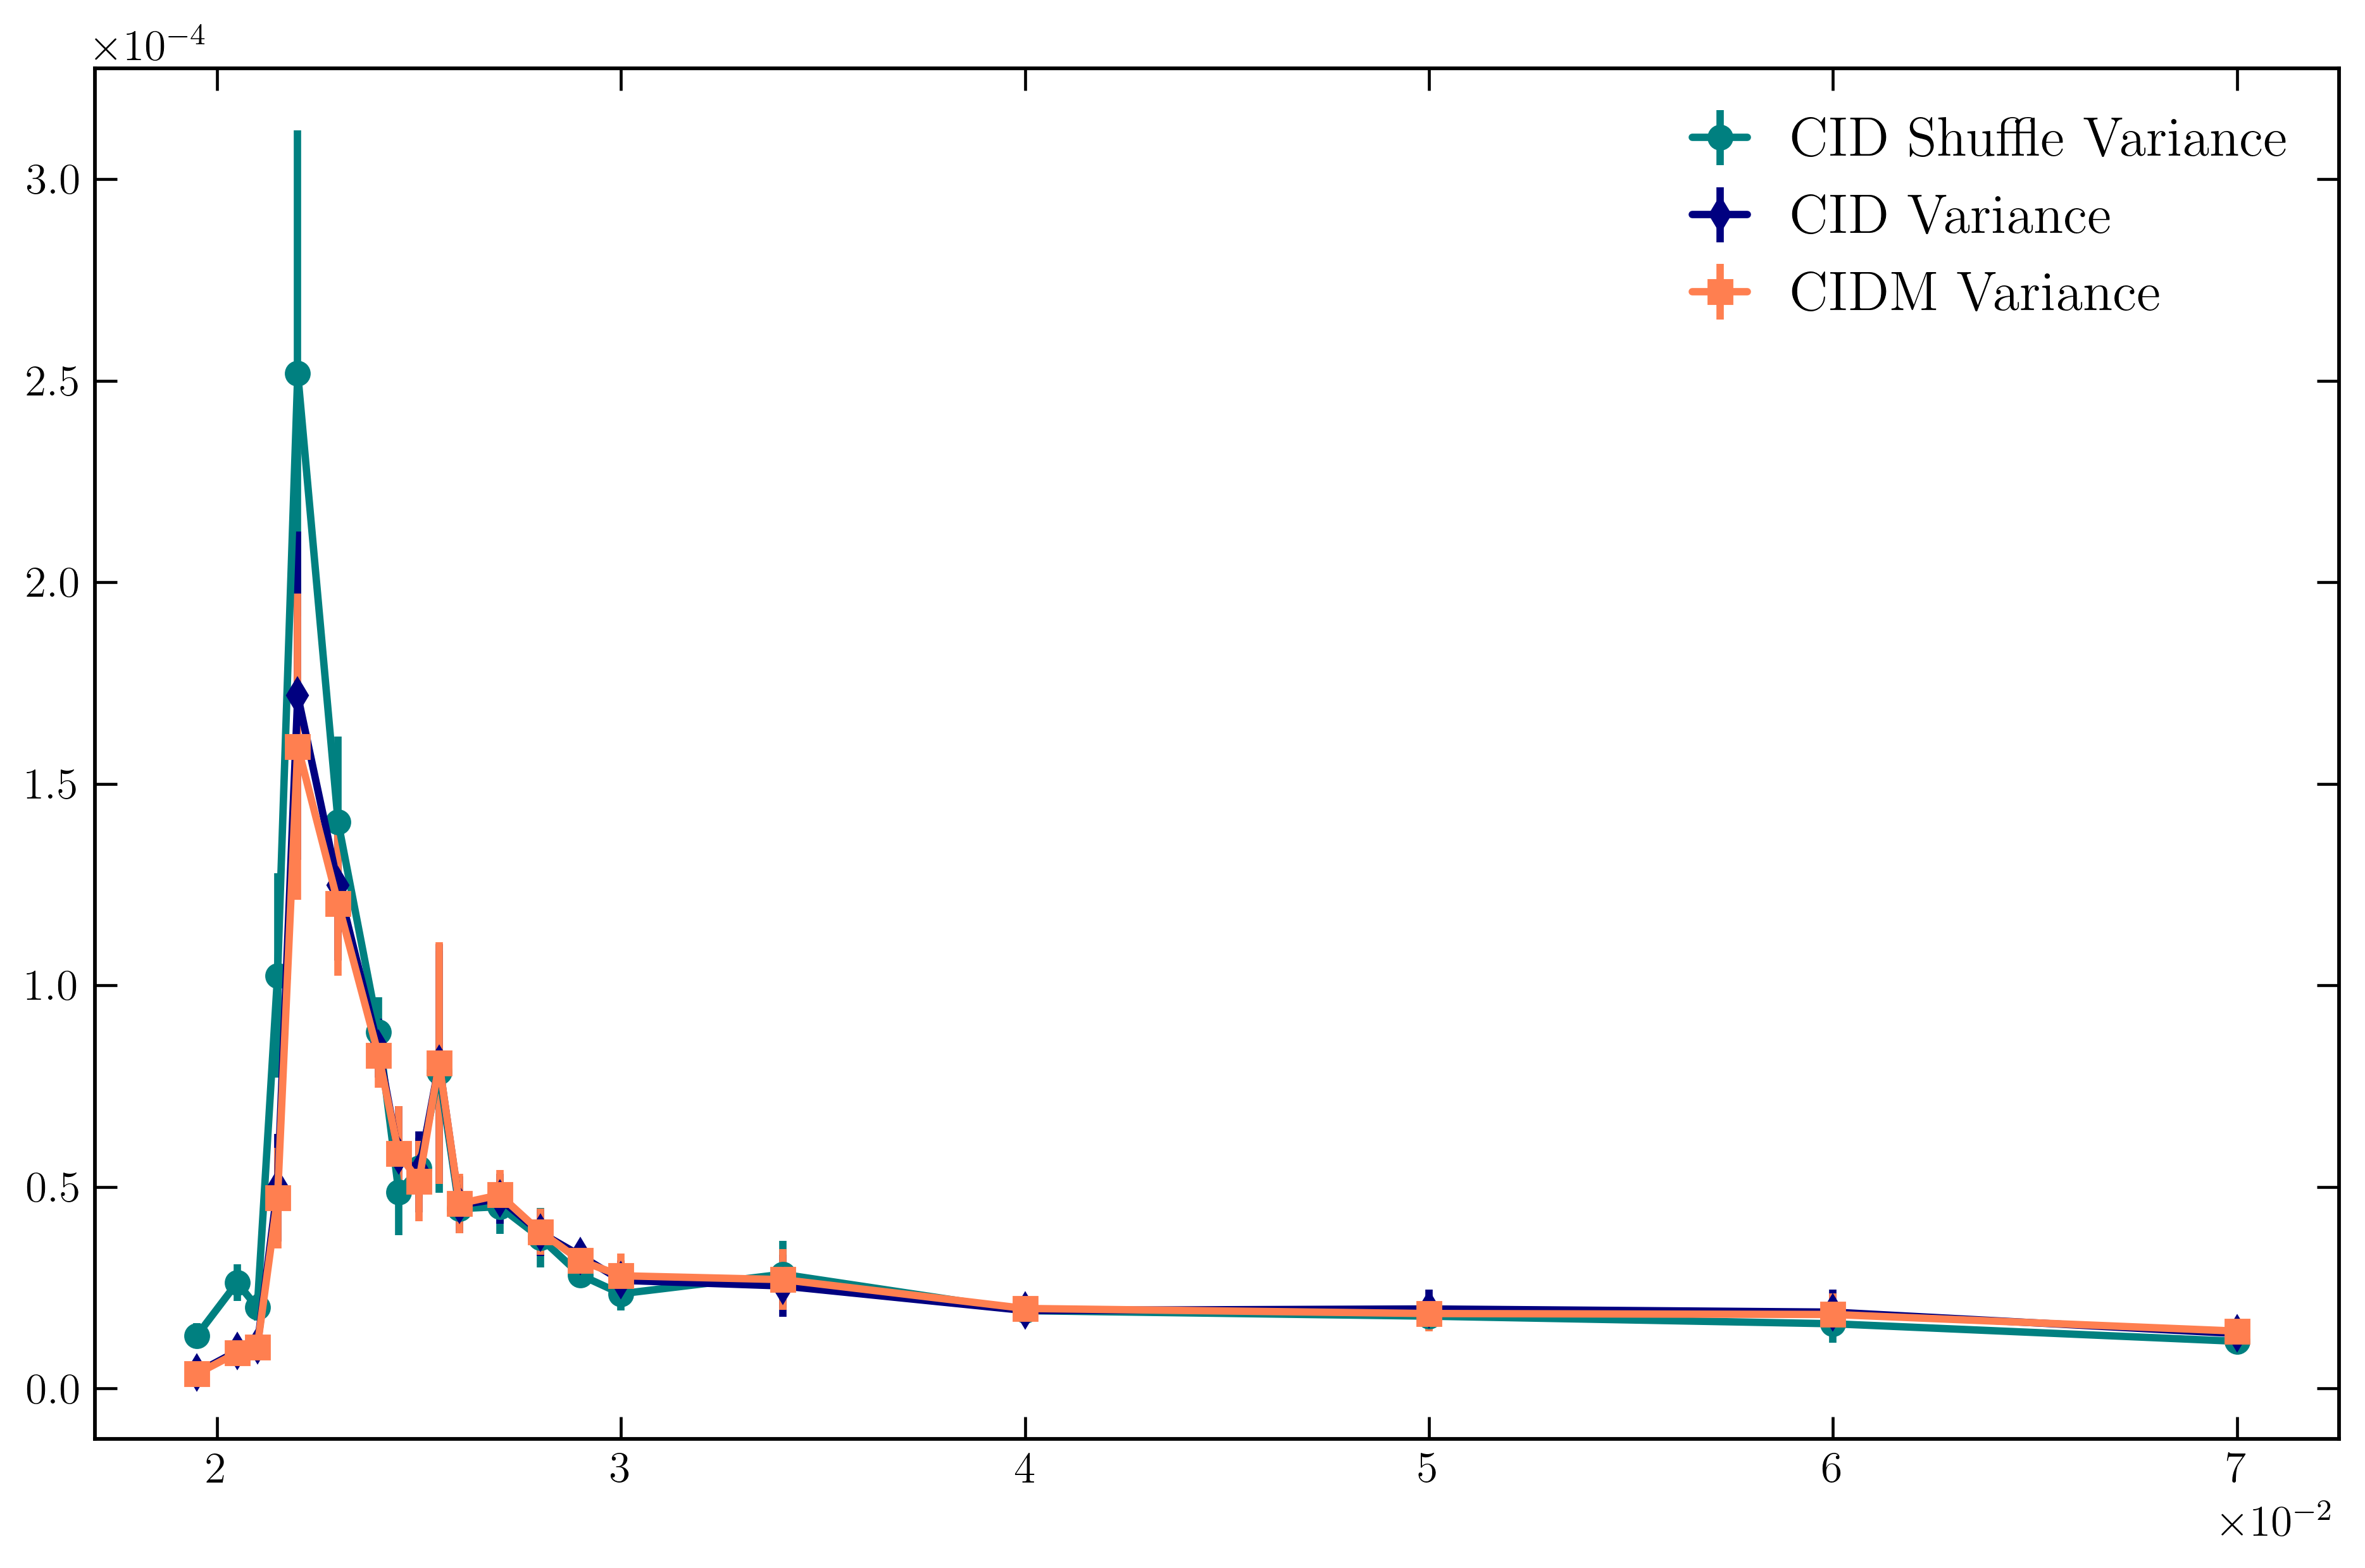

In [18]:
LL = ac.L_list[0]
window_size=256
nframes=64
#cg = data_dict[data_suffix]['cg']
LL = data_dict[data_suffix]['L_list'][0]
ac_list = []

nsizes_list = nsizes_dict[data_suffix]
for size in nsizes_list:
    cid_dict.update(data_dict[data_suffix])
    cg = cid_dict['cg']
    cid_dict.update({
        'output_suffix': f'_nx{window_size}nt{size}cg{cg}' if iterate_frames else f'_nx{size}nt{nframes}cg{cg}',
    })
    ac_tmp = AnalyseCID(cid_dict, load_data=True)
    ac_list.append(ac_tmp)

cs = ac.cid_shuffle[LL][...,0]
cs_var = np.nanvar(cs, axis=(0,1,))
cs_varav = np.nanmean(cs_var, axis=(-1))
cs_varsem = np.nanstd(cs_var, axis=(-1)) / np.sqrt(cs_var.shape[-1])

cid_var = ac.cid_var[LL]
cidm_var = ac.cidm_var[LL]

plt.errorbar(ac.act[LL], cs_varav, yerr=cs_varsem, fmt='o-', label='CID Shuffle Variance')
plt.errorbar(ac.act[LL], cid_var[:,0], yerr=cid_var[:,1], fmt='d-', label='CID Variance')
plt.errorbar(ac.act[LL], cidm_var[:,0], yerr=cidm_var[:,1], fmt='s-', label='CIDM Variance')

#plt.vlines(0.022, 0, 0.015, colors='k', linestyles='dashed', label='$a_c$')
plt.legend()

In [32]:

LX=ac.L_list[0]
actidx=5
expidx=0
compression_factor = ac.cid_params[LX]['compression_factor']
cid_vals=ac.cid[LX][:,:,actidx,expidx,0].reshape(-1, compression_factor, compression_factor)
cid_vals.shape

(50, 16, 16)

In [36]:
# Set correlation parameters
abs_val = True # when True, the degeneracy in the director is resolved
auto_corr_kwargs = {'shift': 2/np.pi if abs_val is True else 9/(7*np.pi),
                    'abs_val': abs_val, 
                    'normalize': True}
auto_corr_kwargs = {'shift': 0,
                    'abs_val': abs_val, 
                    'normalize': True}

origin=True
step=1

rdf, _ = rdf2d_mod(cid_vals[0], corr_func_kwargs = auto_corr_kwargs, \
                                 origin=origin, step=step)